In [2]:
from trading import Asset
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as xp

In [18]:
asset = Asset(
    "LTC",
    start = datetime(2023,3,10),
    end = datetime.now(),
    frequency="3min",
    broker = "binance",
    fiat = "USDT",
    source="db"
)

In [20]:
asset.df

,open,low,high,close,volume
date,,,,,
2023-03-10 06:00:00,74.55,74.55,74.65,74.58,485.179
2023-03-10 06:03:00,74.58,74.57,74.64,74.63,613.591
2023-03-10 06:06:00,74.63,74.36,74.65,74.41,5500.943
2023-03-10 06:09:00,74.42,74.36,74.50,74.37,1822.743
2023-03-10 06:12:00,74.37,74.16,74.38,74.16,2229.824
...,...,...,...,...,...
2023-03-16 18:36:00,78.41,78.37,78.43,78.42,178.306
2023-03-16 18:39:00,78.42,78.37,78.47,78.38,322.427
2023-03-16 18:42:00,78.38,78.25,78.38,78.32,859.526


In [21]:
asset.df["trend"] = asset.ema(60)
asset.df["trend_res"] = asset.df["close"] - asset.df["trend"]
asset.df["season"] = asset.sma( 30, target = "trend_res" )
asset.df["season_res"] = asset.df["trend_res"] - asset.df["season"]

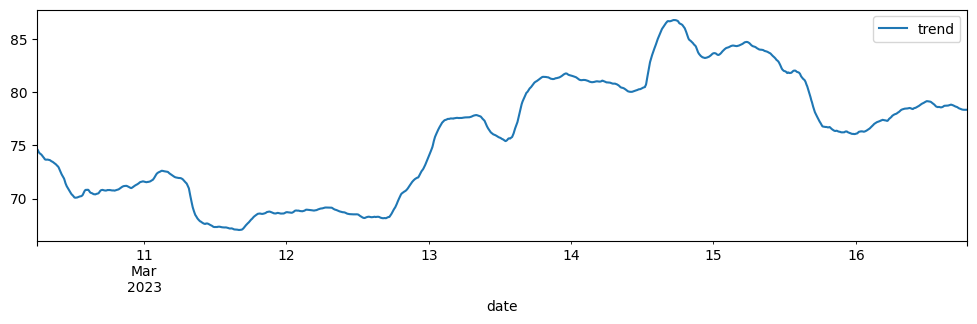

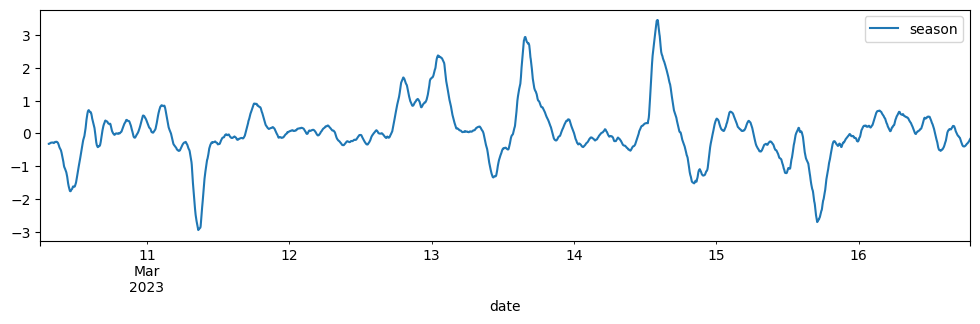

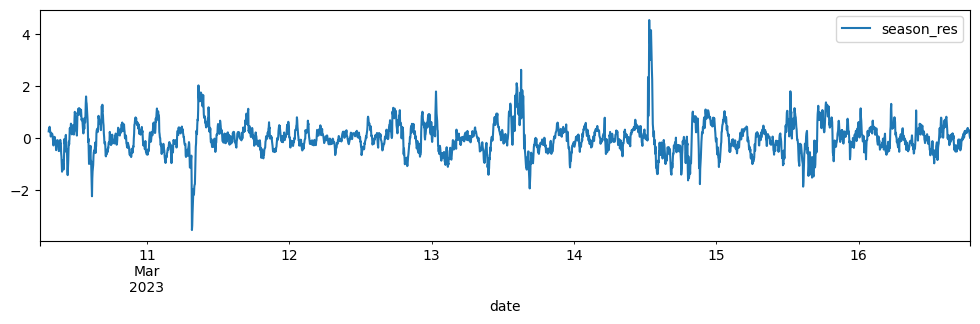

In [22]:
for i in [ "trend", "season", "season_res" ]:
    asset.df[[i]].plot(figsize = (12,3))
    plt.show()

In [23]:
seasonal = asset.df[["season"]].dropna()

In [24]:
# sampling rate
sr = len(seasonal)
# sampling interval
ts = 1/sr
t = np.arange(0,1,ts)

r = round(seasonal["season"].std(), ndigits=2)

reg = []
for i in range(4, 100, 2):
    y = np.sin(np.pi*i*t) * r

    seasonal["sin"] = y

    error  = np.linalg.norm( seasonal["season"] - seasonal["sin"] )

    reg.append([ i, error ])


reg = pd.DataFrame(reg, columns = ["freq", "error"])
xp.scatter( reg, x = "freq", y = "error" )


In [25]:
reg[ reg[ "error" ] == reg["error"].min() ]["freq"].iloc[0]

16

<AxesSubplot:xlabel='date'>

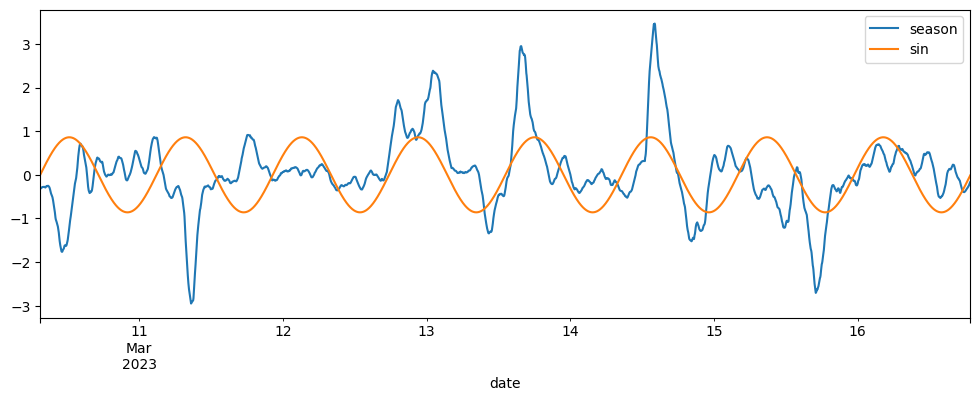

In [26]:
i = reg[ reg[ "error" ] == reg["error"].min() ]["freq"].iloc[0]
y = np.sin(np.pi*i*t)*r

seasonal["sin"] = y
seasonal.plot(figsize = (12,4))

In [28]:
zeros = np.zeros(len(asset.df) - len(y))
asset.df[ "sin" ] = zeros.tolist() + y.tolist()

In [29]:
asset.df["trend sin"] = asset.df["trend"] + asset.df["sin"]

In [30]:
xp.line(asset.df[["sin"]])

In [77]:
asset.df["sin diff"] = asset.df["sin"].diff()

In [81]:
asset.df["buy"] = asset.df["sin"] == asset.df["sin"].min()

In [82]:
def sell_column(asset, target ):
    asset.df["sell"] = False
    true_values = asset.df[ asset.df["buy"] == True ].index.tolist()
    close = asset.df["close"]

    if len(true_values) == 0:
        return asset

    last_value_index = true_values[-1]

    for i in true_values:
        close_price = close[i] # bought price
        close_aux = close[ i: ]
        close_aux = ( close_aux / close_price ) - 1
        pct_index = close_aux[ close_aux >= target ]

        if len(pct_index) == 0:
            # Esta entrada nos indica que como no hay mejor, entonces el retorno de la estrategia 
            # estara ligada al ultrimo precio de nuestro tabal
            # Sera el ultimo precio de la tabla lo que sera considerado como la orden de cierre.
            asset.df.loc[ -1, "sell" ] = True
            # raise Exception( "Testing did not prove a better return." )
            break
        
        pct_index = pct_index.index[0]

        try:
            asset.df.loc[ pct_index, "sell" ] = True
        except Exception as e:
            raise Exception( f"{e}. Got {type(pct_index)} from {pct_index}." )
    
    return asset

In [83]:
asset = sell_column(asset, target = 0.0015)

In [84]:
from trading.testers.rules_testing import rule_validation


In [85]:
df = rule_validation(asset)

In [86]:
df

,date_bought,bought,date_sold,sold,returns,acc
0,2023-03-15 10:55:00,82.21,2023-03-15 12:30:00,82.43,0.003,1.003
1,2023-03-15 16:50:00,76.03,2023-03-15 17:06:00,76.55,0.007,1.010
2,2023-03-15 22:45:00,75.85,2023-03-15 23:04:00,76.01,0.002,1.012
3,2023-03-16 04:40:00,77.24,2023-03-16 05:02:00,77.39,0.002,1.014
4,2023-03-16 10:35:00,79.10,2023-03-16 10:36:00,79.26,0.002,1.016
5,2023-03-16 16:30:00,78.20,2023-03-16 16:40:00,78.32,0.002,1.017
6,2023-03-16 22:25:00,78.67,2023-03-16 23:00:00,78.84,0.002,1.019
